In [1]:
import sys
import os
import astropy.io.fits as fits
import math
import os.path
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import matplotlib.pyplot as plt
import operator
from matplotlib.colors import LogNorm
from photutils.datasets import make_4gaussians_image
from photutils import centroid_com, centroid_1dg, centroid_2dg
import numpy as np
from astropy.visualization import PercentileInterval
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from photutils import CircularAnnulus

In [2]:
# definitions

# def scale_image(scale,time, data_image):
#     scale_num = scale
#     interval = PercentileInterval(scale_num)
#     interval.get_limits(data_image[time,:,:])
#     scale_array = interval(data_image[time,:,:])
#     return scale_array 

def aperture_sum(radius, data, val_x, val_y):
    R = radius
    val_2dg_x = val_x
    val_2dg_y = val_y
    # for positions we will take the 2dg Gaussian outputs.
    positions = [(val_2dg_x, val_2dg_y)]
    apertures = CircularAperture(positions, r=R)
#     print(apertures)
    phot_table = aperture_photometry(data,apertures)
    return phot_table['aperture_sum']

def slicing_im(npix,box):
    npix = npix #total pixels
    box = box #changes the display of arrays
    result= (npix - box)/2
#     print(result)
#     print(result)
    if result % 1 == 0:
        end_num = int(result)
        strt_num = end_num
        new_st = strt_num
        new_end = npix - end_num
    else:
#         end_num = int(round(result,0))
        end_num = result +0.5
        strt_num = end_num - 1
        new_st = strt_num 
        new_end = npix - end_num
#     print("total pixels is: ",npix,'\nLeft side start by:',new_st,"\nRight side end by:",new_end)
    strt = int(new_st)
    end = int(new_end)
    return strt, end

def org_dict(dict_name,str_num_name,com_x,com_y):
    start_ind =0 
    end_ind = 1
    str_arr_list = ["cen_com_arr_x", "cen_com_arr_y"]
    dict_cen = dict_name
# puts each into a seperate array of 15 indexes
    for i in range(0,64):
        dict_cen[str_arr_list[0]+'_'+str(i)] = com_x[start_ind:end_ind]
        dict_cen[str_arr_list[1]+'_'+str(i)] = com_y[start_ind:end_ind]
        start_ind = start_ind + 1
        end_ind = end_ind+1
#creates an array of numbered names.
    str_num_arr=str_num_name
    for j in range(0,64):
        str_name_1 = str_arr_list[0]+'_'+str(j)
        str_name_2 = str_arr_list[1]+'_'+str(j)
        str_num_arr.append(str_name_1)
        str_num_arr.append(str_name_2)
        
def time_arr_func(time_arr,ind_time_arr,frame_t,bmjd_obs):
    frameday = frame_t/(3600*24)
    shift_bmjd = bmjd_obs + 0.5* frameday
    list_bmjd=[shift_bmjd]
    time_arr.append(shift_bmjd)
    ind_time_arr.append(shift_bmjd)
    # Adding onto array.
    for j in range(63):
        value = list_bmjd[0] + (j+1)*frameday
        ind_time_arr.append(value)
        time_arr.append(value)
        
def ifelse_pixel(image,z,x,y,Num_zxy,Num):
    if Num==31:
        if Num_zxy>Num:
            pixelpos=float('NaN')  
        else:
            pixelpos=image[z,x,y]
    elif Num==0:  
        if Num_zxy<Num:
            pixelpos=float('NaN') 
        else:
            pixelpos=image[z,x,y] 
    return(pixelpos)

def replace_nanPixels(dataIm):
    new_dataIm= np.zeros((64,32,32))
    for z in range(int(len(dataIm))):
        for x in range(int(len(dataIm)/2)):
            for y in range(int(len(dataIm)/2)):
                isitnan = math.isnan(dataIm[z,x,y])
                if isitnan == True:
    #                 print(z,x,y)
#                     print('y: ',miny,y,addy)
    #                 print('x: ',minx,x,addx)
                    addy=y+1;miny=y-1;addx=x+1;minx=x-1
    #               ------------------------
                    rightCen = ifelse_pixel(dataIm,z,x,addy,addy,31)
                    leftCen = ifelse_pixel(dataIm,z,x,miny,miny,0)
                    upCen = ifelse_pixel(dataIm,z,minx,y,minx,0)
                    downCen = ifelse_pixel(dataIm,z,addx,y,addx,31)
                    upLeft = ifelse_pixel(dataIm,z,minx,miny,minx,0)
                    upRight = ifelse_pixel(dataIm,z,minx,addy,minx,0)
                    downLeft = ifelse_pixel(dataIm,z,addx,miny,addx,31)
                    downRight = ifelse_pixel(dataIm,z,addx,addy,addy,31)
#                   ------------------------                                  
#                     print(z+1,'(',str(y+1),',',str(x+1),')')
#                     print('upleft pixel:',upLeft)
#                     print('top pixel:',upCen)
#                     print('upright pixel:',upRight)
#                     print('left pixel: ',leftCen)
#                     print('center pixel: ',im[z,x,y])
#                     print('right pixel: ',rightCen)
#                     print('lwleft pixel:',downLeft)
#                     print('bottom pixel:',downCen)
#                     print('lwright pixel:',downRight)
#                    ------------------------  
                    mean_of_c = np.nanmean([leftCen,rightCen,downLeft,downCen,downRight,upLeft,upCen,upRight])
                    new_dataIm[z,x,y] = mean_of_c  
                elif isitnan==False:
                    new_dataIm[z,x,y] = dataIm[z,x,y] 
    return new_dataIm

def ap_range(fileseg,whole_or_part):
#     Used to view a certain amount of file segments 
    fileseg=fileseg
    eqn = fileseg*64
    totval = eqn
    if whole_or_part =='Start':
        strt = 0
    elif whole_or_part == 'Part':
        strt = totval-64
    end = totval
    return(strt,end)

def remove_first_pixel_of_a_segm(ap_phot_arr):
    ap_phot_arr.pop(0)
    k=64
    del ap_phot_arr[k-1::k]

In [3]:
# Creates a new directory for COM (Center of Mass centroid measured) aperture phtometry data since it is already created, 
# we just need the array.
created_dir ='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com'
name_of_file_last = '/com_ap_ph_prt'
# There are 8 folders that contain parts of the light curve either from CH1 or Ch2
val_range = 8
# An empty array that will hold directories of different parts of the light curve,
new_dir_arr=[] 
# Creates a numbered array from 1 to 7 that correlates 
num = np.linspace(1,val_range-1,val_range-1) 
# Uses a for-loop that adds a number to the string of 'name_of_file_last' variable
#  and numbers them as either a whole number or a part of a number.
#  Since the folders were originally numbered: 1,2,3,4,5,6_1,6_2,7...
#  We shall keep it consistent. Since the Python the index starts at 
#  zero we will have to readjust the numbering.
for n_index in range(val_range):
    if n_index == 5:    #if the n_index is five, the sixth folder will have a 
        part_inp = str(6) #folder name that's added with '-6_1'...
        part_num =name_of_file_last+part_inp+"-1"
    elif n_index == 6:   #if the n_index is six, the seventh folder will have a 
        part_inp = str(6) #folder name that's added with '-6_2'...
        part_num =name_of_file_last+part_inp+"-2"
    elif n_index == 7:   #if the n_index is seven, the eighth folder will have a 
        part_inp = str(7) #folder name that's added with '-7'...
        part_num =name_of_file_last+part_inp
    else:               #Anything that's below the fifth index, will be named
                        # according to the variable,'num', array.
        part_inp = str(int(num[n_index])) 
        part_num =name_of_file_last+part_inp
#     print(part_num) #Prints out the output of the folder names.
#     Joining two strings together and creating it as a new directory.
    save_dir = created_dir + part_num+'/'
#     Adds this string directory into the 'new_dir_arr' array.
#      Note that this new directoy does not exist yet.
    new_dir_arr.append(save_dir) 

##   Checks to see if the the folder exist and if it's not, it creates it. 
##   Otherwise, it is not need since it is already created.
#     print("Created directory:",save_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        new_dir_arr.append(save_dir)
print(new_dir_arr) #Shows the list of new existing directories

['/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt1/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt2/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt3/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt4/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt5/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt6-1/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt6-2/', '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt7/']


In [4]:
# Treating the bcd directories into an array
tot_dir_bcd = ['/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_1',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_2',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_3',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_4',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_5',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_6-1',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_6-2',
           '/Users/melaniapena/Rsrch/Luhman_16_Research/bcd_files/only_bcd_part_7',]
col_1='AperturePhot'
col_2='bmjd'
part_num = 3 #Choose what folder to go through to create the Aperture Photometry.
ori_dir = new_dir_arr[part_num-1]
print(ori_dir)


/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt3/


In [5]:
phot_ap_arr =[] #full light curve of folder
time_arr = []   #full array
cen_com_arr_x=[]#full x centroid of folder
cen_com_arr_y=[]#full y centroid of folder
apPh_1=[]
apPh_2=[]
apPh_3=[]

m = 0
i_box = 6 ##pixel box size that we want as 7x7 (sub box)
scale_num = 100
npix = 32 #total size of the pixel where it's 32x32.

if part_num == 2 or part_num == 4 or part_num == 5:
    r_1 = 7
    r_2 = 11
    r_3 = 14
else:
    r_1 = 7
    r_2 = 11
    r_3 = 14
r_1

7

In [6]:
# i=0
# # only focus on COM centroid for aperture photometry
# for filename in os.listdir(tot_dir_bcd[part_num-1]):
#     if filename.endswith(".fits"): 
# #         Joins the two strings together to create a variable of the directory that  
# #         will already have the list of file segments. (one folder will have about 200 files.)
# #         Only loops through file names that ends with '.fits' .
#         dir_bcd = os.path.join(tot_dir_bcd[part_num-1],filename)
#         fits_file = fits.open(dir_bcd)             # Opens the directory of the bcd fits file.
#         list_Primary = fits_file[0]                # Takes out Primary header from fits file.

# #         Takes out specific information from the primary header.
# #         bmjd_obs = fits_file[0].header['BMJD_OBS'] # Time measured as bmjd
# #         mjd_obs = fits_file[0].header['MJD_OBS']
# #         AINTBEG = fits_file[0].header['AINTBEG'] 
# #         ATIMEEND = fits_file[0].header['ATIMEEND'] 
#         RA = fits_file[0].header['RA_HMS']
#         DEC = fits_file[0].header['DEC_DMS']

# #         print('bcd',i,'MJD: ',mjd_obs,' BMJD:',bmjd_obs)
#         print('bcd',i,(bmjd_obs-mjd_obs)*24*60)
#         print('RA:',RA,'DEC:',DEC)
#         print('')
#         i=i+1
# #         -----------------------------------------------
# #         Time array
# ind_time_arr = []
# time_arr_func(time_arr,ind_time_arr,frame_t,bmjd_obs)

In [7]:
# print('beg',AINTBEG)
# print('end',ATIMEEND)
# print('space between them: ',(ATIMEEND-AINTBEG)/63)

# test_array=[AINTBEG]
# step = (ATIMEEND-AINTBEG)/63
# for i in range(63):
# #     print(i)
#     if i == 0:
#         val = test_array[0]+step
#         test_array.append(val)
# #         print(val)
#     else:
#         val = test_array[i]+step
#         test_array.append(val)
#         print(val)

# print(test_array[0],test_array[63])
# test_array


# # #  One that we created for BMJD
# # def time_arr_func(time_arr,ind_time_arr,frame_t,bmjd_obs):
# #     frameday = frame_t/(3600*24)
# #     shift_bmjd = bmjd_obs + 0.5* frameday
# #     list_bmjd=[shift_bmjd]
# #     time_arr.append(shift_bmjd)
# #     ind_time_arr.append(shift_bmjd)
# #     # Adding onto array.
# #     for j in range(63):
# #         value = list_bmjd[0] + (j+1)*frameday
# #         ind_time_arr.append(value)
# #         time_arr.append(value)

In [8]:
# only focus on COM centroid for aperture photometry
for filename in os.listdir(tot_dir_bcd[part_num-1]):
    if filename.endswith(".fits"): 
#         Joins the two strings together to create a variable of the directory that  
#         will already have the list of file segments. (one folder will have about 200 files.)
#         Only loops through file names that ends with '.fits' .
        dir_bcd = os.path.join(tot_dir_bcd[part_num-1],filename)
        fits_file = fits.open(dir_bcd)             # Opens the directory of the bcd fits file.
        fits_data = get_pkg_data_filename(dir_bcd) # Receives the data from the fits file directory.
        list_Primary = fits_file[0]                # Takes out Primary header from fits file.
        image_data= fits.getdata(fits_data, ext=0) # Receive the image data from 'fits_data'. 
        
        
#         if part_num==2 or part_num==4 or part_num==5: # There are some folders w/ files that has 'NaN' values,
#             image_data=replace_nanPixels(image_data)  # so replace_nanPixel def will replace those pixels.
                                                      # using the average value of the surrounding pixels.
    
#         Takes out specific information from the primary header.
        flux_conv= fits_file[0].header['FLUXCONV'] #Flux conversion
        bmjd_obs = fits_file[0].header['BMJD_OBS'] # Time measured as bmjd
        frame_t = fits_file[0].header['FRAMTIME']  # Frame time
        gain = fits_file[0].header['GAIN']         # The Gain
        exp_time= fits_file[0].header['EXPTIME']   #Exp time
#         The gain, exp_time and flux_conv will be used to calcluate 
#          a conversion value to be multiplied by the image_data.
# #         -----------------------------------------------
# #         Time array
        ind_time_arr = []
        time_arr_func(time_arr,ind_time_arr,frame_t,bmjd_obs)
#         --------------------------------------------------
        conversion_factor = gain*exp_time/flux_conv 
        counts_image = image_data * conversion_factor
#         counts_image = image_data
#         -----------------------------------------------
#         x and y Centroids
        centroid_com_arr_x = [] #save list of 64 values of x centroid into array
        centroid_com_arr_y = [] #save list of 64 values of y centroid into array
#         print('delta x/y:'+str((npix-i_box)/2)) # Displays the delta of x and y will be about 12.5 ((32-7)/2)
#         print('Box Size: ', i_box,'x',i_box)    # Displays the value of given box size.
        strt, end = slicing_im(npix,i_box)        # Uses a def that returns a value that will be used to slice the image.
#         Uses a for loop to go through the z value within the file 
#         and each z value it will measure the x and y centroids of the image.
        for z in range(0,64): 
            interval = PercentileInterval(scale_num)
            interval.get_limits(counts_image[z,strt:end,strt:end])
            scale_array = interval(counts_image[z,strt:end,strt:end])
#             sliced_image = counts_image[z,strt:end,strt:end]
            x, y = centroid_com(scale_array) #Measures the x and y centroids
            delta = (npix-i_box)/2 -.5 
            xc = x+delta
            yc = y+delta
            centroid_com_arr_x.append(xc) # Saves into an array from the file.
            centroid_com_arr_y.append(yc) 
            cen_com_arr_x.append(xc)      # Saves into an array of the whole folder.
            cen_com_arr_y.append(yc) 
#             print(i_box,strt,end)
#             print('COM: ',xc,yc)
#             print(num,z,'\n')
        str_num_arr=[]  #The empty array 'str_num_arr' and dictionary 'dict_cen' will help 
        dict_cen = {}   #organize the list of centroids thats taken out of each file.
#         The line below is a def function that organizes the centroids 
#         So that it is easier to call back when needed to measuring the aperture photometry.
        org_dict(dict_cen,str_num_arr,centroid_com_arr_x,centroid_com_arr_y) 
#         -----------------------------------------------
#         Aperture Photometry

#         focuses on the indiviual array of the photo data.
        ind_photometry_arr =[]
        h_com = 0 ##starting index for 2dG
        index_box = 0 ##measuring the box size ex 3x3....31x31. this is set in index tho
                       #index for 7x7 is now only zero    
        for l in range(0,64):
            aperture_1 = aperture_sum(r_1,counts_image[l,:,:], dict_cen[str_num_arr[h_com]][index_box], dict_cen[str_num_arr[h_com+1]][index_box]) 
            aperture_2 = aperture_sum(r_2,counts_image[l,:,:], dict_cen[str_num_arr[h_com]][index_box], dict_cen[str_num_arr[h_com+1]][index_box])
            aperture_3 = aperture_sum(r_3,counts_image[l,:,:], dict_cen[str_num_arr[h_com]][index_box], dict_cen[str_num_arr[h_com+1]][index_box])

            apPh_1.append(aperture_1)#The three append functions below are there in case 
            apPh_2.append(aperture_2)# you need to opserve the Aperture Photometry 
            apPh_3.append(aperture_3)# of the sky annulus or the aperture of the image. 
            
#             Area of aperture:
            area_1 = math.pi * r_1**2
#             Background in annulus from r_2 to r_3:
            background_counts = aperture_3 - aperture_2
#             Area of Annulus:
            area_2 = math.pi*(r_3**2 - r_2**2) #also known as npix
#             subtracting background: 
            backgrnd_subtract = aperture_1 - background_counts*area_1/area_2
            ind_photometry_arr.append(backgrnd_subtract)
            phot_ap_arr.append(backgrnd_subtract)
            h_com = h_com+2
#             print(backgrnd_subtract)

#         -----------------------------------------------
#         Saves the aperture,time, and centroids into an individual ascii array
        if part_num==6:
            str_m='_part_6-1'
        elif part_num==7:
            str_m='_part_6-2'
        elif part_num==8:
            str_m='_part_7'
        else:
            str_m='_part_'+str(part_num) 
        word=ori_dir+'bcdfits_com_'+str(m)+str_m+'.txt'
        print(m)
        m+=1
        ind_arr_table = Table([ind_photometry_arr,ind_time_arr,centroid_com_arr_x,centroid_com_arr_y], names=[col_1,col_2,'x_com_cen','y_com_cen'])
#         ascii.write(ind_arr_table, word, format='tab', fast_writer=False)   
#         -----------------------------------------------
# We create a whole new variable with the same data sets.
# The reason why I call it sliced will be explained in the next comment
sliced_paa= phot_ap_arr[:] 
sliced_time = time_arr[:]
sliced_cenx = cen_com_arr_x[:]
sliced_ceny = cen_com_arr_y[:]
# I created a definition that removes the first ap_photometry value in each file segment.
# Meaning that when plotting the whole line of the light curve. We will not be seeing an 'echo'
# of the light curve data set. we do the same for the time, x and y centroid to keep the length 
# of the arrays consistent.
remove_first_pixel_of_a_segm(sliced_paa)
remove_first_pixel_of_a_segm(sliced_time)
remove_first_pixel_of_a_segm(sliced_cenx)
remove_first_pixel_of_a_segm(sliced_ceny)
if part_num==6:
    str_m='part_6-1'
elif part_num==7:
    str_m='part_6-2'
elif part_num==8:
    str_m='part_7'
else:
    str_m='part_'+str(part_num)
word=ori_dir+'bcdfits_com_'+str_m+'.txt'
Tot_arr_table = Table([sliced_paa,sliced_time,sliced_cenx,sliced_ceny], names=[col_1,col_2,'x_com_cen','y_com_cen'])
# ascii.write(Tot_arr_table, word, format='tab', fast_writer=False) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [9]:
def ap_range(fileseg,whole_or_part):
#     Used to view a certain amount of file segments 
    fileseg=fileseg
    eqn = fileseg*64
    totval = eqn
    if whole_or_part =='Start':
        strt = 0
    elif whole_or_part == 'Part':
        strt = totval-64
    end = totval
    return(strt,end)
def median_flux(ap_ph):
    ap_ph_med = ap_ph/np.nanmedian(ap_ph)
    return ap_ph_med

62 126
64
64


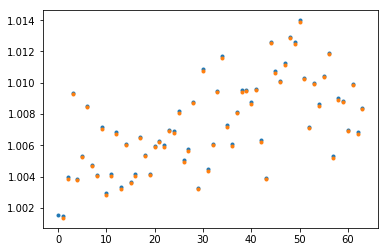

In [10]:
samp= phot_ap_arr[:]
samp_h = time_arr[:]
cut_samp_h = samp_h[:]
cut_samp= samp[:];

remove_first_pixel_of_a_segm(cut_samp);
remove_first_pixel_of_a_segm(cut_samp_h);
cut_samp = median_flux(cut_samp)

samp = median_flux(samp)
set_n = 2

st,ed = ap_range(set_n,'Part')
# print(samp[st]) #First value in the selected datacube.

# lightcurve_1=ori_dir+ 'bcdfits_part_'+str(part_num)+'.txt'
# plt.figure(figsize=(10,5))
# plt.ylabel('Flux')
# plt.xlabel('Number of data points')
# plt.title('Aperture Photometry (One data cube)'+'\n data cube #'+str(set_n) )
# plt.ylim(440000,470000)
# plt.ylim(0.960,1.020)
# This is the photometry in the course of one datacube 
# We want to understand why the first data value in each datacube is found at a consistent value..
# plt.plot(samp[st:ed],'.')
# plt.show()

chge = -set_n
shifted_cut = cut_samp[chge+st:ed+chge]
shifted_cut = shifted_cut[1:]
x_ax1 = np.linspace(0,63,64)
x_ax2 = np.linspace(1,63,63)
plt.plot(x_ax1,samp[st:ed],'.')
plt.plot(x_ax2,shifted_cut,'.')

print(chge+st,chge+ed)
print(len(samp[st:ed]))
print(len(cut_samp[chge+st:ed+chge]))

In [11]:
import matplotlib.lines as lines
First_point_in_datacube = []
pos_in_point_data_cube = []

# # Checks the average of every first value of each datacube(one data cube has 64 aperture photometry values)
# # print(samp[0],'\n...')
# # -----------------------------------------------------------------------------------
list = os.listdir(ori_dir) # dir is your directory path
number_files = len(list)-1
print('Number of files within this folder: ',number_files)
for n in range(number_files):
#     n=64
    st,ed = ap_range(n,'Part')
    pos_in_point_data_cube.append(ed)
    First_point_in_datacube.append(samp[ed])
#     print(samp[ed])
print('Length of light curve with first point of each datacube:',len(First_point_in_datacube))
print('Average: ',np.mean(First_point_in_datacube))
print(len(samp))
# # -----------------------------------------------------------------------------------
# st,ed = ap_range(set_n,'Start')
hour = []
for i in range(len(samp_h)):
    initial = samp_h[0]
    hr_v=(samp_h[i]-initial)*24   
    hour.append(hr_v)
    
cut_hour = []
for i in range(len(cut_samp_h)):
    initial = cut_samp_h[0]
    hr_v=(cut_samp_h[i]-initial)*24   
    cut_hour.append(hr_v)

hour_rev=[]
pos_in_point_data_cube
for i in pos_in_point_data_cube:
    hour_rev.append(hour[i])

Number of files within this folder:  150
Length of light curve with first point of each datacube: 150
Average:  0.9908821425403104
9600


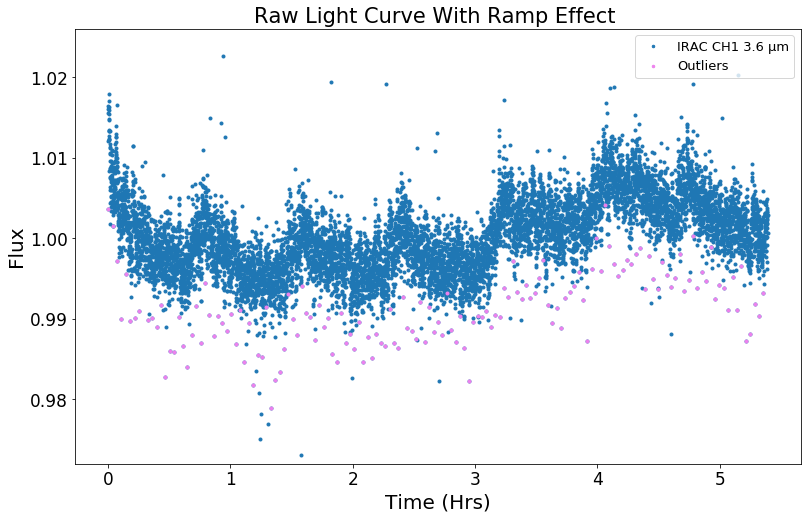

In [36]:
titlesize = 21;xylabelsize=20;xyticksize=17;legsize=13

plt.figure(figsize=(13,8))
plt.title('Raw Light Curve With Ramp Effect ',fontsize=titlesize)
plt.ylabel('Flux',fontsize=xylabelsize)
plt.xlabel('Time (Hrs)',fontsize=xylabelsize)
# This is the photometry in the course of one datacube 
# We want to understand why the first data value in each datacube at a
plt.ylim(0.972,1.026);#plt.xlim(-1000,19880)
plt.plot(hour,samp,'.',label='Aperture Photometry CH1')
# plt.plot(samp[st:ed],'.',color='teal')
plt.plot(hour_rev,First_point_in_datacube,'.',label='Outliers', color='violet')
plt.xticks(fontsize=xyticksize)
plt.yticks(fontsize=xyticksize)
# plt.legend(loc='upper right');plt.show()
lgd1 = lines.Line2D([], [],linestyle='None', marker='.', markersize=5, label="IRAC CH1 "+"3.6 "+ u"\u03bcm")
lgd2 = lines.Line2D([], [], color='Violet', linestyle='None', marker='.', markersize=5, label='Outliers')
lgd=plt.legend(handles=[lgd1,lgd2],prop={'size': legsize},loc=1, ncol=1)
art = []
art.append(lgd)
save_figure = "/Users/melaniapena/Desktop/Seg_Lc_Outliers.png"
plt.savefig(save_figure,dpi=600,additional_artisits=art, bbox_inches="tight")


# plt.figure(figsize=(13,8));
# plt.ylim(0.968,1.020);#plt.xlim(-1000,19880-295)
# plt.plot(cut_hour,cut_samp,'.',label='Aperture Photometry CH1');plt.ylim(0.968,1.020)
# plt.ylabel('Flux')
# plt.xlabel('Time (Hours)')
# plt.title('First Segment of Whole Light Curve (Outliers ommited)')
# # plt.legend(loc='upper right');plt.show()
# lgd1 = lines.Line2D([], [],linestyle='None', marker='.', markersize=5, label='Segment 1: IRAC CH1 3.6 microns')
# # lgd2 = lines.Line2D([], [], color='Violet', linestyle='None', marker='.', markersize=5, label='Outliers')
# lgd=plt.legend(handles=[lgd1],loc=4, ncol=1)
# art = []
# art.append(lgd)
# save_figure = "/Users/melaniapena/Desktop/Seg_Lc_full_outliers_gone.png"
# plt.savefig(save_figure,dpi=600,additional_artisits=art, bbox_inches="tight")



# plt.figure(figsize=(13,8));
# plt.ylim(0.968,1.020);#plt.xlim(-1000,19880)
# plt.plot(hour,samp,'.',label='IRAC CH1 3.6 microns');plt.ylim(0.968,1.020)
# plt.ylabel('Flux',fontsize=13)
# plt.xlabel('Time (Hours)',fontsize=13)
# # plt.title('Aperture Photometry w/ Outliers')
# plt.title('First Segment of Whole Light Curve',fontsize=16)
# # plt.legend(loc='upper right');plt.show()

# lgd1 = lines.Line2D([], [],linestyle='None', marker='.', markersize=5, label='Segment 1: IRAC CH1 3.6 microns')
# # lgd2 = lines.Line2D([], [], color='Violet', linestyle='None', marker='.', markersize=5, label='Outliers')
# lgd=plt.legend(handles=[lgd1],loc=1, ncol=1)
# art = []
# art.append(lgd)
# save_figure = "/Users/melaniapena/Desktop/Seg_Lc_full.png"
# plt.savefig(save_figure,dpi=600,additional_artisits=art, bbox_inches="tight")

In [13]:
# fig, axs = plt.subplots(2)
# fig.suptitle('Vertically stacked subplots')
# axs[0].plot(x, y)
# axs[1].plot(x, -y)


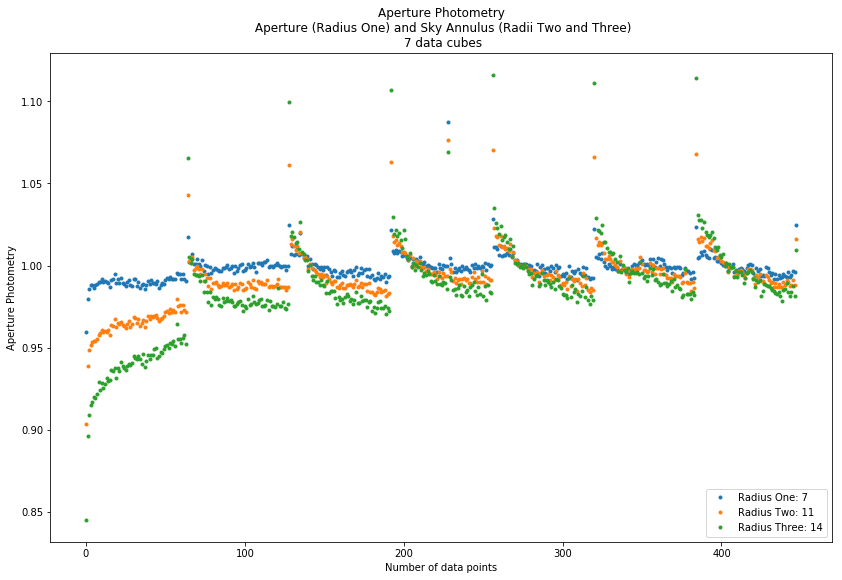

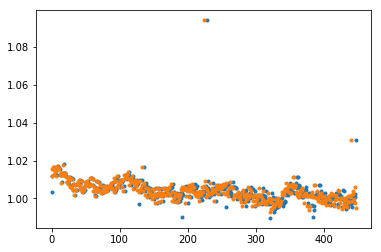

In [106]:
set_n = 7
apPh_r1 = apPh_1[:];apPh_r1= median_flux(apPh_r1)
apPh_r2 = apPh_2[:];apPh_r2= median_flux(apPh_r2)
apPh_r3 = apPh_3[:];apPh_r3= median_flux(apPh_r3)

st,ed = ap_range(set_n,'Part') #If you want to see a certain single datacube section form the apPhot
st,ed = ap_range(set_n,'Start') #Show's the number amount of datacubes on the plot

str1 = 'Radius One: '+str(r_1)
str2 = 'Radius Two: '+str(r_2)
str3 = 'Radius Three: '+str(r_3)

plt.figure(figsize=(14,9))
plt.title('Aperture Photometry\n Aperture (Radius One) and Sky Annulus (Radii Two and Three)\n '+str(set_n)+' data cubes')

plt.plot(apPh_r1[st:ed],'.',label= str1)
plt.plot(apPh_r2[st:ed],'.',label= str2)
plt.plot(apPh_r3[st:ed],'.',label= str3)
plt.ylabel('Aperture Photometry')
plt.xlabel('Number of data points')

plt.legend(loc='lower right');plt.show()

